<a href="https://colab.research.google.com/github/anhle199/Demo-Stock-Price-Prediction/blob/master/predict_future_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed
4/4 [==============================] - 2s 19ms/step


<ipython-input-12-725c750a3f67>:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dataset['Predictions'] = closing_price_prediction


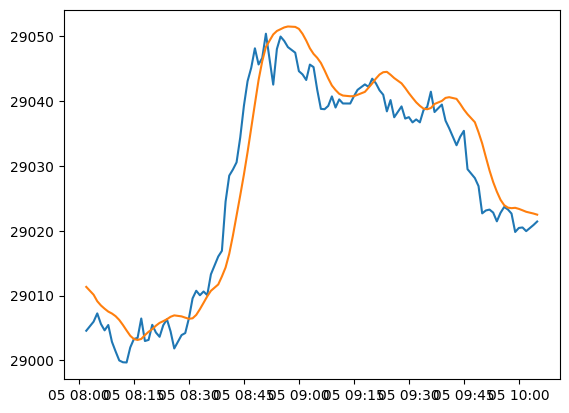

In [12]:
from keras.layers import Dense, LSTM
from keras.models import Sequential
import numpy as np
from pandas import DataFrame, RangeIndex, to_datetime
import yfinance as yf
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


DEFAULT_MODEL_DATASET_PATH = '../model_dataset/'
TRAIN_SIZE = 0.8
STEPS = 60


def build_model_filename(crypto_name: str, path=DEFAULT_MODEL_DATASET_PATH) -> str:
    prefix = path if path.endswith('/') else path + '/'
    return f'{prefix}{crypto_name}_lstm_model.keras'


def download_live_cryptocurrency_data(name: str, currency: str, period: str, interval: str) -> DataFrame:
    data = yf.download(tickers=f"{name}-{currency}", period=period, interval=interval)
    data.insert(0, "Date", data.index)
    data.index = RangeIndex(0, len(data), 1)
    return data


def split_dataset(dataset, train_size=TRAIN_SIZE):
    index = int(len(dataset) * train_size)
    return dataset[:index], dataset[index:]


def prepare_dataset(crypto_name: str, period: str, interval: str) -> DataFrame:
    dataset = download_live_cryptocurrency_data(crypto_name, 'USD', period, interval)
    dataset['Date'] = to_datetime(dataset.Date, format='%Y-%m-%d')
    sorted_dataset = dataset.sort_values(by='Date', ascending=True, axis=0)
    filtered_dataset = DataFrame(data=sorted_dataset.Close.to_numpy(), index=sorted_dataset.Date, columns=['Close'])
    return filtered_dataset


def normalize_dataset(dataset: DataFrame, train_dataset, scaler):
    scaled_data = scaler.fit_transform(dataset.values)

    x_train, y_train = [], []
    for i in range(STEPS, train_dataset.shape[0]):
        x_train.append(scaled_data[i - STEPS : i, 0])
        y_train.append(scaled_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    print(x_train.shape)
    return x_train, y_train


def train_lstm_model(x_train_data, y_train_data):
    lstm_model = Sequential()
    lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train_data.shape[1], 1)))
    lstm_model.add(LSTM(units=50))
    lstm_model.add(Dense(1))

    lstm_model.compile(loss="mean_squared_error", optimizer="adam")
    lstm_model.fit(x_train_data, y_train_data, epochs=1, batch_size=1, verbose="2")

    return lstm_model


def get_sample_dataset(dataset: DataFrame, scaler):
    _, valid_data = split_dataset(dataset.values)
    inputs = dataset[len(dataset) - len(valid_data) - 60 :].values
    inputs = inputs.reshape(-1, 1)
    return scaler.transform(inputs)


def predict_close_price(model, scaler, inputs):
    X_test = []
    for i in range(STEPS, inputs.shape[0]):
        X_test.append(inputs[i - STEPS : i, 0])
    X_test = np.array(X_test)

    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    closing_price = model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)

    return closing_price


# def moving_test_window_preds(test_data, scaler, start, n_future_preds):

#     # Declare variable where we store the prediction made on each window and the moving input window
#     prediction = []
#     moving_input_window = []

#     # Set the inputs
#     inputs = test_data.reset_index(drop=True).values
#     inputs = scaler.transform(inputs)

#     moving_input_window.append(inputs[start:(start + steps), :])
#     moving_input_window = np.array(moving_input_window)
#     moving_input_window = np.reshape(moving_input_window, (moving_input_window.shape[0], moving_input_window.shape[1], 9))

#     # Loop over the amount of future predictions we want to make
#     for i in range(n_future_preds):

#         # Predict the next price based on the moving_input_window
#         y_hat = model.predict(moving_input_window)

#         # Append y_hat to predictions
#         prediction.append(y_hat[0,:])

#         # Reshape y_hat for concatenation with moving test window
#         y_hat = y_hat.reshape(1,1,9)

#         # Remove first element
#         moving_input_window = np.concatenate((moving_input_window[:,1:,:], y_hat),axis=1)

#     prediction = scaler.inverse_transform(DataFrame(prediction))

#     return prediction


# download dataset
raw_dataset = download_live_cryptocurrency_data("BTC", 'USD', "1d", "1m")

raw_dataset['Date'] = to_datetime(raw_dataset.Date, format='%Y-%m-%d')
sorted_dataset = raw_dataset.sort_values(by='Date', ascending=True, axis=0)
filtered_dataset = DataFrame(data=sorted_dataset.Close.to_numpy(), index=sorted_dataset.Date, columns=['Close'])
train_dataset, test_dataset = split_dataset(filtered_dataset)

# load prebuilt model
model_filename = build_model_filename("BTC")
model = load_model(model_filename)

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_dataset.values)

# prepare sample dataset to predict
_, sample_test_data = split_dataset(filtered_dataset.values)
inputs = filtered_dataset[len(filtered_dataset) - len(sample_test_data) - STEPS :].values
inputs = scaler.transform(inputs.reshape(-1, 1))

# predict closing price
closing_price_prediction = predict_close_price(model, scaler, inputs)
# future_prediction = moving_test_window_preds(test_dataset, scaler, 0, 20)

test_dataset['Predictions'] = closing_price_prediction

plt.plot(test_dataset[['Close', 'Predictions']])